In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.tseries.offsets import DateOffset

# Load data

In [2]:
datapath = Path('Data')
fcpath = Path('Forecasts')

In [4]:
# Function to read reservoir data
def read_reservoir_data(name):
    WL = pd.read_csv(datapath / 'Waterlevel' / (name+'.csv'), index_col='FLOW_DATE', parse_dates=True)
    WL = WL.loc[:, ['PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS']]
    for c in WL.columns:
        WL.loc[:, c] = pd.to_numeric(WL.loc[:,c], errors='coerce')
    
    WL.columns = ['Storage', 'Level', 'Inflow', 'Outflow']
    
    #TMC to m3
    WL.Storage = WL.Storage * 28316846.59
    
    #CUSECS to m3/s
    WL.Inflow = WL.Inflow * 0.028316847
    WL.Outflow = WL.Outflow * 0.028316847
    WL = WL.sort_index().astype(np.float64)
    WL = WL[~WL.index.duplicated(keep='first')]
    
    ind = pd.date_range(WL.index[0], WL.index[-1], freq='1D')
    WL_ = pd.DataFrame(index = ind, columns = WL.columns)
    for c in WL_.columns:
        WL_.loc[WL_.index.isin(WL.index), c] = pd.to_numeric(WL.loc[:,c], errors='coerce')
    
    return WL_.astype(np.float64).interpolate(method='time')

In [5]:
#Read reservoir data, not KRS because data is lacking.
reservoirs = ['Harangi', 'Hemavathi', 'Kabini']
reservoir_data = {r: read_reservoir_data(r) for r in reservoirs}

In [6]:
#Function to read the forecast data af multiple forecast horizons.
#Returns a dictionary with the forecast DataFrames
def get_fcdata():
    
    fcdata = {}
    for t in ['Monthly', 'Weekly', 'Daily']:
        fcdata[t] = {}
        for r in reservoirs:
            try:
                fcdata[t][r] = pd.read_csv(fcpath / t / 'Online training' / (r+'.csv'), index_col=0, parse_dates=True)
            except:
                print(r+', '+t+': Failed.')
    return fcdata

fcdata = get_fcdata()

In [7]:
#The forecasted quantiles
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [8]:
#Load weather data for the plots
weather_area = pd.read_csv(datapath / 'Weather' / 'land_area_weighted.csv', index_col=0, parse_dates=True, skiprows=2).resample('1D').sum()
rain_mon = pd.DataFrame(index = pd.date_range(pd.to_datetime('01-01-2010 00:00', dayfirst=True), pd.to_datetime('01-12-2019 00:00', dayfirst=True), freq='MS'), columns=reservoirs)

rain_mon.loc[:, 'Kabini'] = pd.to_numeric(pd.read_csv(datapath / 'Weather' / 'sum_precip_monthly_Kabini.csv').precip, errors='coerce').values * 11100**2 / 7074490388
rain_mon.loc[:, 'Harangi'] = pd.to_numeric(pd.read_csv(datapath / 'Weather' / 'sum_precip_monthly_Harangi.csv').precip, errors='coerce').values * 11100**2 / 525693758
rain_mon.loc[:, 'Hemavathi'] = pd.to_numeric(pd.read_csv(datapath / 'Weather' / 'sum_precip_monthly_Hemavathi.csv').precip, errors='coerce').values * 11100**2 / 2885180049

rain_daily = pd.read_csv(datapath / 'Weather' / 'sum_precip_daily.csv', index_col=1, parse_dates=True)
rain_daily.loc[:, 'Kabini'] = rain_daily.loc[:, 'Kabini']*5500*5500/7074490388
rain_daily.loc[:, 'Harangi'] = rain_daily.loc[:, 'Harangi']*5500*5500/525693758
rain_daily.loc[:, 'Hemavathi'] = rain_daily.loc[:, 'Hemavathi']*5500*5500/2885180049

# Daily

In [9]:
def plot_daily_singlefc(reservoir, startdate):
    """
    Function that takes the reservoir name and startdate, and plots the 7-day ahead forecasts with 1-day resolution.
    Quantile values are plotted as red area around the expected value.
    """
    ind = pd.date_range(startdate, startdate+pd.Timedelta('6D'), freq='1D')
    fc = fcdata['Daily'][reservoir].copy()
    act = reservoir_data[reservoir].copy().Inflow
    
    fc = fc.loc[fc.index.isin(ind)]
    act = act.loc[act.index.isin(ind)]
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    for q in quantiles[:6]:
        up = [fc.loc[ind[0], 'd'+str(d)+' q'+str(q)] for d in range(1,len(ind)+1)]
        down = [fc.loc[ind[0], 'd'+str(d)+' q'+str(1-q)] for d in range(1,len(ind)+1)]
        ax.fill_between(ind, down, up, color='red', alpha=0.5*q)
    
    med = [fc.loc[ind[0], 'd'+str(d)+' q0.5'] for d in range(1,len(ind)+1)]
    
    ax.plot(ind, med, '--r')
    ax.plot(ind, act)
    ax.set_ylim(0, None)
    ax.set_ylabel('Discharge [m3/s]')
    plt.xlim(ind[0], ind[-1])
    
    prec = rain_daily.copy().resample('1D').sum()
    ax2 = ax.twinx()
    ax2.bar(ind, prec.loc[prec.index.isin(ind), reservoir], alpha=0.5)
    ax2.set_ylim(0, 100)
    
    ax.set_xlim(ind[0], ind[-1])
    ax2.set_xlim(ind[0], ind[-1])
    ax2.set_ylabel('Precipitation [mm]')
    plt.xlim(ind[0], ind[-1])
   
    

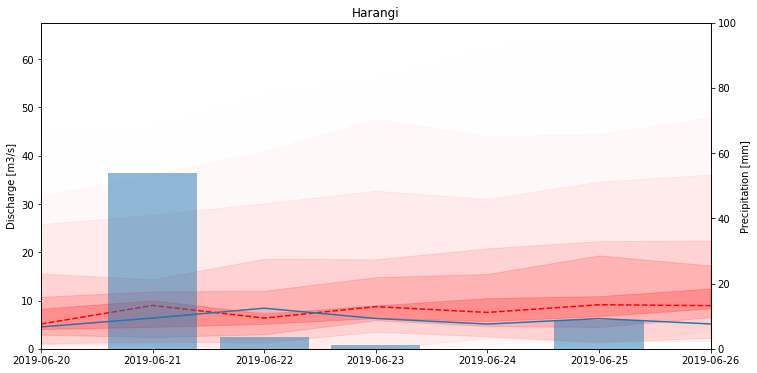

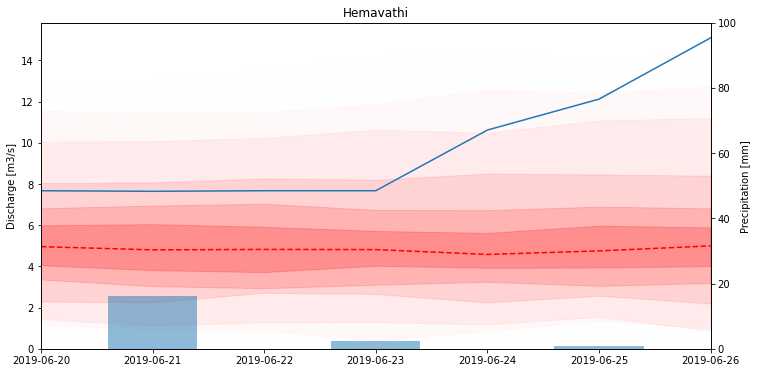

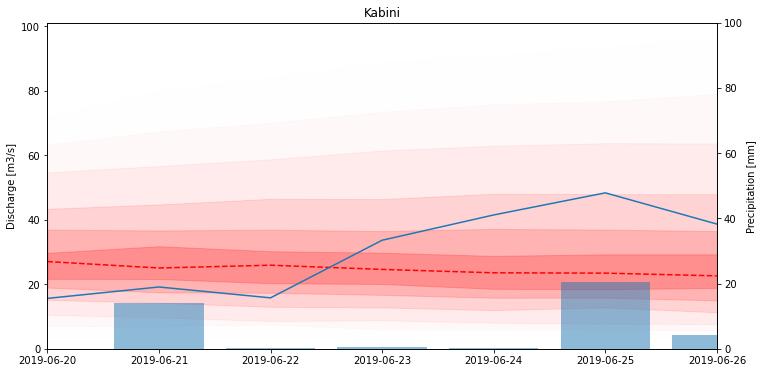

In [11]:
#PLot for reservoirs and date
sd = pd.to_datetime('20-6-2019 00:00', dayfirst=True)
for r in reservoirs:
    try:
        plot_daily_singlefc(r, sd)
        plt.title(r)
    except:
        pass

# One step ahead

In [12]:
def plot_daily_onestep(reservoir, startdate): 
    """
    Function that takes the reservoir name and startdate, and plots the 1-day ahead forecasts for the 7 days ahead.
    Quantile values are plotted as red area around the expected value.
    """
    ind = pd.date_range(startdate, startdate+DateOffset(days=7), freq='D')
    ind = [ind[i] for i in range(len(ind)) if ind[i] < pd.to_datetime('24-12-2019 00:00', dayfirst=True)]
    
    fc = fcdata['Daily'][reservoir].copy()
    act = reservoir_data[reservoir].copy().resample('D').mean().Inflow
    
    fc = fc.loc[fc.index.isin(ind)]
    act = act.loc[act.index.isin(ind)]
    
    fig, ax = plt.subplots(figsize=(12,6))
    for q in quantiles[:6]:
        up = [fc.loc[ind[d], 'd1 q'+str(q)] for d in range(len(ind))]
        down = [fc.loc[ind[d], 'd1 q'+str(1-q)] for d in range(len(ind))]
#         ax.plot(ind, down, color='red', alpha=q)
#         ax.plot(ind, up, color='red', alpha=q)
        plt.fill_between(ind, down, up, color='red', alpha=0.5*q)
    
    med = [fc.loc[ind[d], 'd1 q0.5'] for d in range(len(ind))]
    
    ax.plot(ind, med, '-r')
    ax.plot(ind, act)
    ax.set_ylabel('Inflow [m3/s]')
    
    plt.xlim(ind[0], ind[-1])
    
    ax2 = ax.twinx()
    
    prec = rain_daily.copy().resample('1D').sum()
    
    ax2.bar(ind, prec.loc[prec.index.isin(ind), reservoir], alpha=0.5, width=0.05)
    ax2.set_ylim(0, 300)
    ax2.set_ylabel('Precipitation [mm]')
    
    ax.set_xlim(ind[0], ind[-1])
    ax2.set_xlim(ind[0], ind[-1])
    plt.xlim(ind[0], ind[-1])
    
    ax.set_title(reservoir + ' - Daily forecasts')

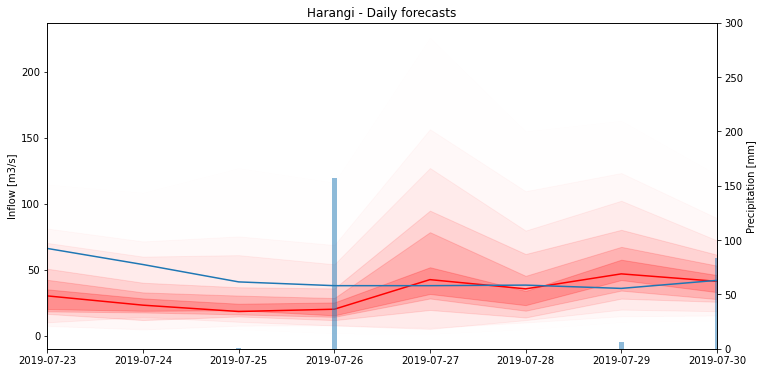

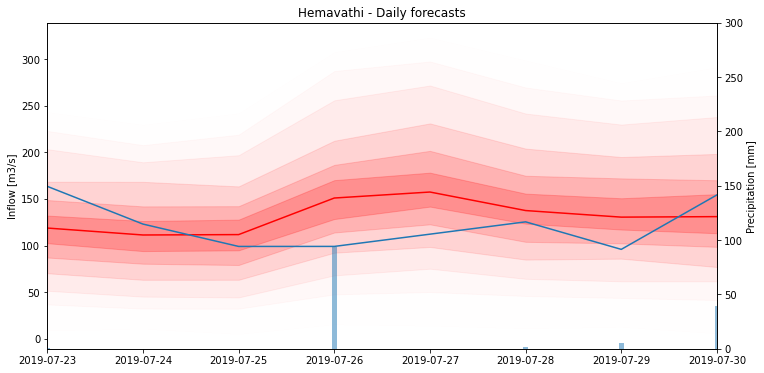

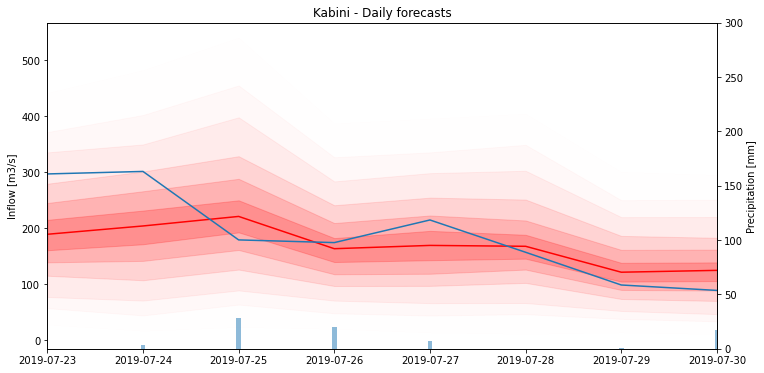

In [13]:
sd = pd.to_datetime('23-07-2019 00:00', dayfirst=True)
for r in reservoirs:
    plot_daily_onestep(r, sd)

# Weekly

## Single FC

In [14]:
def plot_weekly_singlefc(reservoir, startdate):
    """
    Function that takes the reservoir name and startdate, and plots the 12-day ahead forecasts with 1 week resolution.
    Quantile values are plotted as red area around the expected value.
    """
    ind = pd.date_range(startdate, startdate+DateOffset(weeks=11), freq='W-SAT')
    fc = fcdata['Weekly'][reservoir].copy()
    act = reservoir_data[reservoir].copy().resample('W-SAT').mean().Inflow
    
    fc = fc.loc[fc.index.isin(ind)]
    act = act.loc[act.index.isin(ind)]
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    for q in quantiles[:6]:
        up = [fc.loc[ind[0], 'w'+str(d)+' q'+str(q)] for d in range(1,len(ind)+1)]
        down = [fc.loc[ind[0], 'w'+str(d)+' q'+str(1-q)] for d in range(1,len(ind)+1)]
#         ax.plot(ind, down, color='red', alpha=q)
#         ax.plot(ind, up, color='red', alpha=q)
        ax.fill_between(ind, down, up, color='red', alpha=0.5*q)
    
    med = [fc.loc[ind[0], 'w'+str(d)+' q0.5'] for d in range(1,len(ind)+1)]
    
    ax.plot(ind, med, '--r')
    ax.plot(ind, act)
    
    plt.xlim(ind[0], ind[-1])
    
    ax2 = ax.twinx()
    prec = rain_daily.copy().resample('W-SAT').sum()
    ax2.bar(ind, prec.loc[prec.index.isin(ind), reservoir], alpha=0.5)


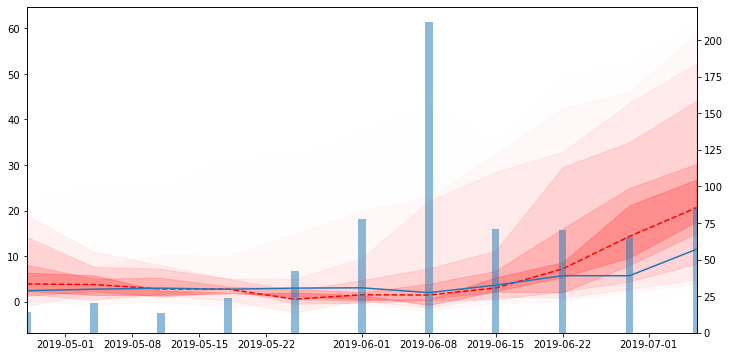

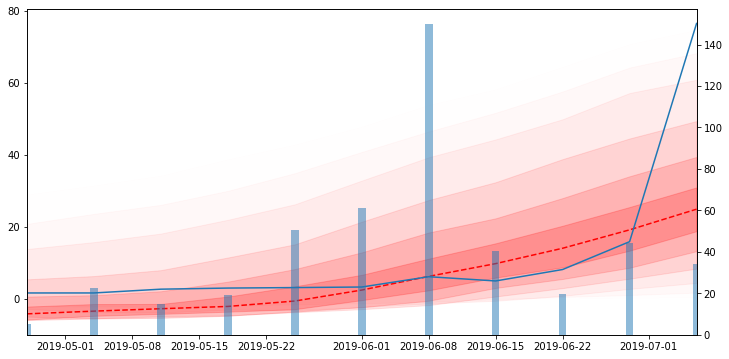

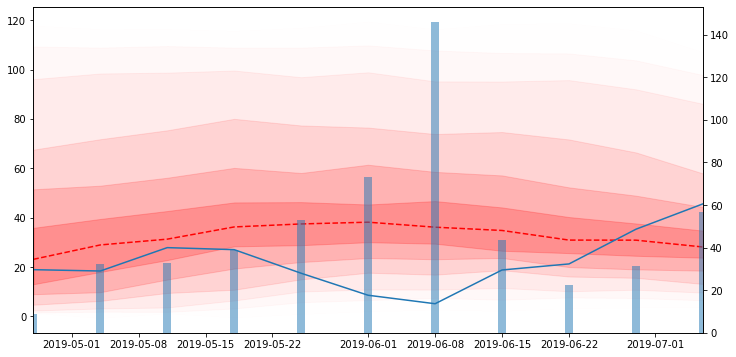

In [15]:
sd = pd.to_datetime('24-04-2019 00:00', dayfirst=True)
for r in reservoirs:
    plot_weekly_singlefc(r, sd)

## One step ahead

In [16]:
def plot_weekly_onestep(reservoir, startdate):
    """
    Function that takes the reservoir name and startdate, and plots the 7-day ahead forecasts for the coming year.
    Quantile values are plotted as red area around the expected value.
    """
    ind = pd.date_range(startdate, startdate+DateOffset(months=11), freq='W-SAT')
    ind = [ind[i] for i in range(len(ind)) if ind[i] < pd.to_datetime('26-10-2019 00:00', dayfirst=True)]
    
    fc = fcdata['Weekly'][reservoir].copy()
    act = reservoir_data[reservoir].copy().resample('W-SAT').mean().Inflow
    
    fc = fc.loc[fc.index.isin(ind)]
    act = act.loc[act.index.isin(ind)]
    
    fig, ax = plt.subplots(figsize=(12,6))
    for q in quantiles[:6]:
        up = [fc.loc[ind[d], 'w1 q'+str(q)] for d in range(len(ind))]
        down = [fc.loc[ind[d], 'w1 q'+str(1-q)] for d in range(len(ind))]
#         ax.plot(ind, down, color='red', alpha=q)
#         ax.plot(ind, up, color='red', alpha=q)
        plt.fill_between(ind, down, up, color='red', alpha=0.5*q)
    
    med = [fc.loc[ind[d], 'w1 q0.5'] for d in range(len(ind))]
    
    ax.plot(ind, med, '-r')
    ax.plot(ind, act)
    ax.set_ylabel('Inflow [m3/s]')
    
    plt.xlim(ind[0], ind[-1])
    
    ax2 = ax.twinx()
    
    ax2.bar(ind, rain_daily.loc[rain_daily.index.isin(ind), reservoir].resample('W-SAT').sum())
    ax2.set_ylim(0, 700)
    ax2.set_ylabel('Precipitation [mm]')
    
    plt.title(reservoir+' - Weekly forecasts', fontsize=14)

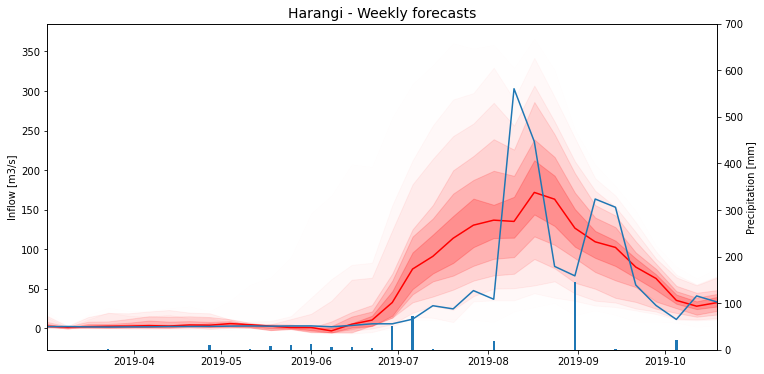

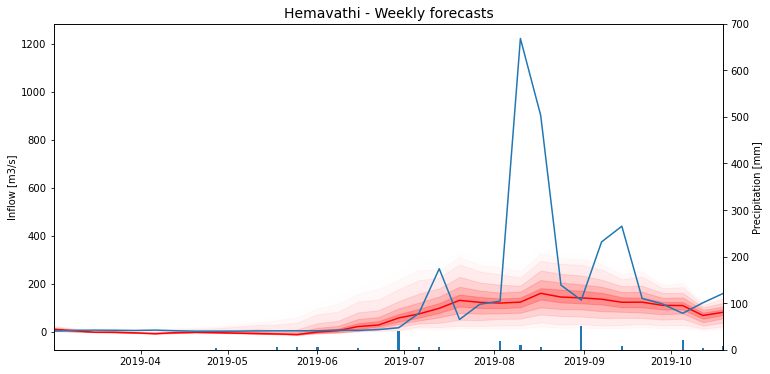

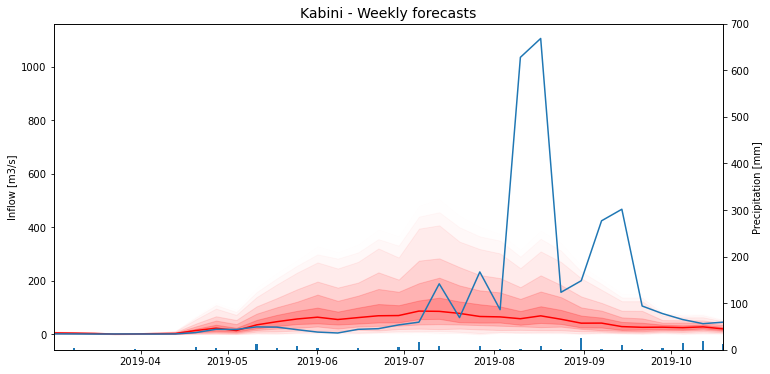

In [17]:
sd = pd.to_datetime('01-03-2019 00:00', dayfirst=True)
for r in reservoirs:
    plot_weekly_onestep(r, sd)

# Monthly

In [18]:
def plot_monthly_singlefc(reservoir, startdate):
    ind = pd.date_range(startdate, startdate+DateOffset(months=2), freq='MS')
#     print(startdate, startdate+pd.Timedelta('3M'),ind)
    fc = fcdata['Monthly'][reservoir].copy()
    act = reservoir_data[reservoir].copy().resample('MS', origin='start_day').mean().Inflow
    
    fc = fc.loc[fc.index.isin(ind)]
    act = act.loc[act.index.isin(ind)]
    
    plt.figure(figsize=(12,6))
    for q in quantiles[:6]:
        up = [fc.loc[ind[0], 'm'+str(d)+' q'+str(q)] for d in range(1,len(ind)+1)]
        down = [fc.loc[ind[0], 'm'+str(d)+' q'+str(1-q)] for d in range(1,len(ind)+1)]
        plt.fill_between(ind, down, up, color='red', alpha=0.5*q)
#         plt.fill_between(ind, down, up, color='red', alpha=q)
    
    med = [fc.loc[ind[0], 'm'+str(d)+' q0.5'] for d in range(1,len(ind)+1)]
    
    plt.plot(ind, med, '--r')#, where='mid')
    plt.plot(ind, act)#, where='mid')
    
    plt.xlim(ind[0], ind[-1])
    plt.title(reservoir + ' - Monthly forecast')
    

In [19]:
# fcdata['Monthly']['Harangi']
fcdata = get_fcdata()

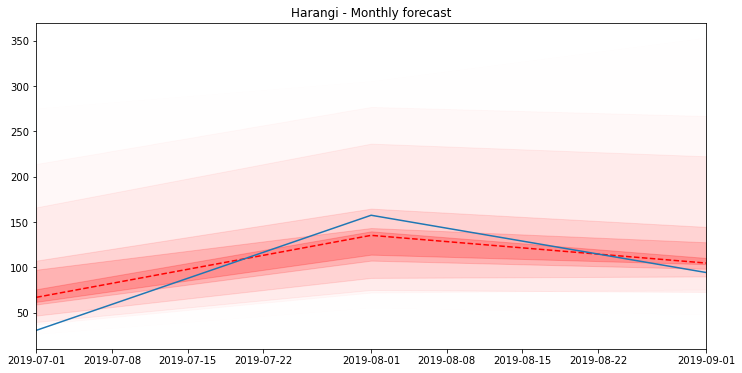

In [20]:
sd = pd.to_datetime('01-07-2019 00:00', dayfirst=True)
plot_monthly_singlefc('Harangi', sd)

## One step ahead

In [21]:
def plot_monthly_onestep(reservoir, startdate):
    """
    Function that takes the reservoir name and startdate, and plots the 1-month ahead forecasts for the coming year.
    Quantile values are plotted as red area around the expected value.
    """
    ind = pd.date_range(startdate, startdate+DateOffset(months=11), freq='MS')
    ind = [ind[i] for i in range(len(ind)) if ind[i] < pd.to_datetime('31-10-2019 00:00', dayfirst=True)]
    
    fc = fcdata['Monthly'][reservoir].copy()
    act = reservoir_data[reservoir].copy().resample('MS', origin='start_day').mean().Inflow
    
    fc = fc.loc[fc.index.isin(ind)]
    act = act.loc[act.index.isin(ind)]
    
    fig, ax = plt.subplots(figsize=(12,6))
    plt.title(None)
    for q in quantiles[:6]:
        up = [fc.loc[ind[d], 'm1 q'+str(q)] for d in range(len(ind))]
        down = [fc.loc[ind[d], 'm1 q'+str(1-q)] for d in range(len(ind))]
#         ax.plot(ind, down, color='red', alpha=q)
#         ax.plot(ind, up, color='red', alpha=q)
        plt.fill_between(ind, down, up, color='red', alpha=0.5*q)
    
    med = [fc.loc[ind[d], 'm1 q0.5'] for d in range(len(ind))]
    
    ax.plot(ind, med, '-r')
    ax.plot(ind, act)
    ax.set_ylabel('Inflow [m3/s]')
    
    plt.xlim(ind[0], ind[-1])
    
    ax2 = ax.twinx()
    
    ax2.bar(ind, rain_mon.loc[rain_mon.index.isin(ind), reservoir], alpha=0.5)
    ax2.set_ylim(0, 10)
    ax2.set_ylabel('Precipitation [mm]')
    ax.set_title(reservoir + ' - Monthly forecast', fontsize=15)
#     ax2.set_title(None)



In [22]:
fcdata = get_fcdata()

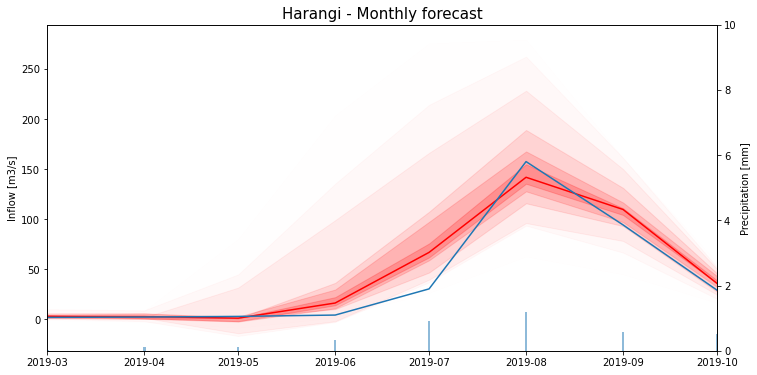

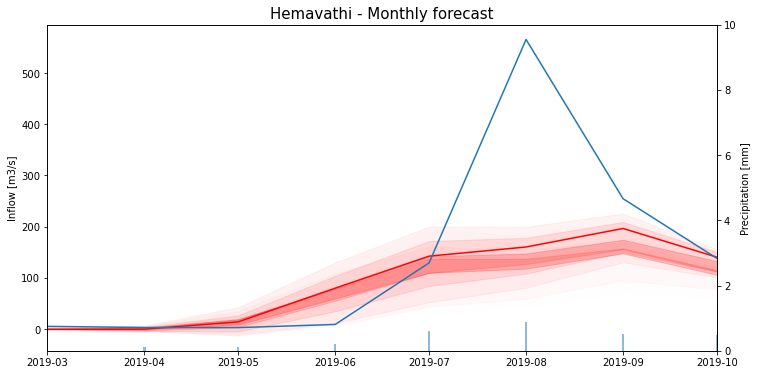

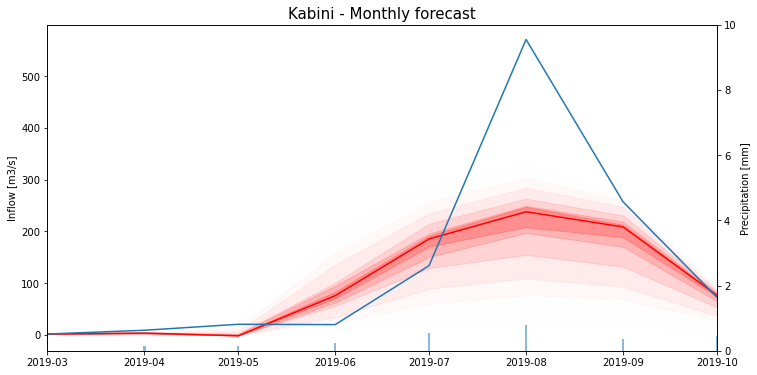

In [23]:
sd = pd.to_datetime('01-03-2019 00:00', dayfirst=True)
for r in reservoirs:
    try:
        plot_monthly_onestep(r, sd)
    except:
        pass

# Combined

In [29]:
# Make a combined plot with the several resolutions available.

sd = pd.to_datetime('1-06-2019', dayfirst=True)
ind = pd.date_range(sd, sd+DateOffset(months=3), freq='1D')
res = 'Harangi'
success=0

temp = pd.DataFrame(index=ind, columns=quantiles)
while success==0:
    try:
        #Fill daily
        fctemp = fcdata['Daily'][res].copy()
        for d in range(1,8):
            for q in quantiles:
                temp.loc[sd + DateOffset(days=d-1), q] = fctemp.loc[sd, 'd'+str(d)+' q'+str(q)]

        #Fill weekly

        fctemp = fcdata['Weekly'][res].copy()

        for w in range(2,5):
            for q in quantiles:
                temp.loc[sd + DateOffset(weeks=w-1), q] = fctemp.loc[sd, 'w'+str(w)+' q'+str(q)]

        fctemp = fcdata['Monthly'][res].copy()
        sd_m = pd.to_datetime('01-07-2019', dayfirst=True)
        for m in range(1,3):
            for q in quantiles:
                temp.loc[sd_m + DateOffset(months=m-1), q] = fctemp.loc[sd_m, 'm'+str(m)+' q'+str(q)]


        temp = temp.astype(np.float64).interpolate()
        success=1
    except:
        sd = sd + DateOffset(days=1)

Text(0, 0.5, 'Inflow [m3/s]')

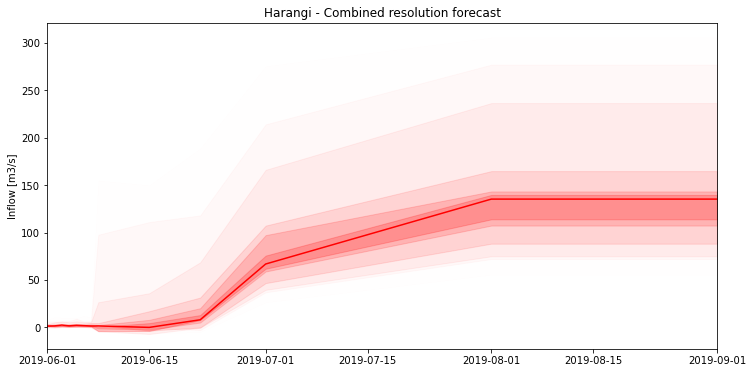

In [31]:
plt.figure(figsize=(12,6))
plt.title(res+' - Combined resolution forecast')
for q in quantiles[:6]:
    plt.fill_between(temp.index, temp.loc[:, 1-q], temp.loc[:, q], color='r', alpha=0.5*q)
    
plt.plot(temp.index, temp.loc[:, 0.5], color='r')
plt.xlim(ind[0], ind[-1])
plt.ylabel('Inflow [m3/s]')

In [159]:
def plot_monthly_multistep(reservoir, startdate):
    ind = pd.date_range(startdate, startdate+DateOffset(months=11 + 2), freq='MS')
    ind = [ind[i] for i in range(len(ind)) if ind[i] < pd.to_datetime('31-12-2019 00:00', dayfirst=True)]
    fc = fcdata['Monthly'][reservoir].copy()
    act = reservoir_data[reservoir].copy().resample('MS', origin='start_day').mean().Inflow
    
    fc = fc.loc[fc.index.isin(ind)]
    act = act.loc[act.index.isin(ind)]
    
    plt.figure(figsize=(12,6))
    for q in quantiles:
        for i_i, i in enumerate(ind):
            line = [fc.loc[i, 'm'+str(m)+' q'+str(q)] for m in range(1,4)]
            print(line)
            ind_ = [ind[i_i + n] for n in range(3)]
            print(ind_)
            
            for d in range(len(ind_)):
                print(d)
                plt.plot([ind_[d], ind_[d+1]], [line[d], line[d+1]], alpha=min(1-q, q)/d, color='r')#C'+str(i_i))
    
    plt.plot(ind, act)
    
    plt.xlim(ind[0], ind[-1])
    plt.ylabel('Discharge [m3/s]')
    

In [171]:
fcdata = get_fcdata()

# Performance metrics

In [196]:
def PICP(act, fc, PI, pred_hor = 1):
    freq = fc.columns[0][0]
    try:
        return (1 - ((act < fc.loc[:, freq+str(pred_hor)+' q'+str(PI)]).sum() + (act > fc.loc[:, freq+str(pred_hor)+' q'+str(1-PI)]).sum() ) / len(act.index)) * 100
    except KeyError:
        return (1 - ((act < fc.loc[:, freq+str(pred_hor)+' q'+str(PI)]).sum() + (act > fc.loc[:, freq+str(pred_hor)+' q'+str(np.round(1-PI, decimals=2))]).sum() ) / len(act.index)) * 100

def PINAW(act, fc, PI, pred_hor = 1):
    D = act.max() - act.min() #dam.std()
    freq = fc.columns[0][0]
    try:
        return (fc.loc[:, freq+str(pred_hor)+' q'+str(PI)] - fc.loc[:, freq+str(pred_hor)+' q'+str(1-PI)]).mean() / D * 100
    except KeyError:
        return (fc.loc[:, freq+str(pred_hor)+' q'+str(np.round(1-PI, decimals=2))] - fc.loc[:, freq+str(pred_hor)+' q'+str(PI)]).mean() / D * 100

In [197]:
def MAE(act, fc, pred_hor=1):
    freq = fc.columns[0][0]
    
    return (fc.loc[:, freq+str(pred_hor)+' q0.5'] - act).abs().mean()

def NSE(act, fc, pred_hor=1):
    freq = fc.columns[0][0]
    uf = (fc.loc[:, freq+str(pred_hor)+' q0.5'] - act)**2
    lf = (act - act.mean())**2
    
    return 1 - uf.sum()/lf.sum()

In [202]:

pred_hors = {
    'Monthly': [1, 2, 3],
    'Weekly': [1, 2, 3, 4],
    'Daily': [1, 2, 3, 4, 5, 6, 7]
}
resolution = {'Monthly': 'MS', 'Weekly': 'W-SAT', 'Daily': 'D'}

In [220]:
metrics = {}

for k in fcdata.keys():
   
    ind = pd.MultiIndex.from_product(iterables=[[r for r in reservoirs], pred_hors[k]], names=['Reservoir', 'Pred. hor.'])
    metric_df = pd.DataFrame(index = ind)
    
    for r in reservoirs:
        fc = fcdata[k][r].copy()
        act = reservoir_data[r].copy().resample(resolution[k]).mean()
        act = act.loc[act.index.isin(fc.index), 'Inflow']
        
        for hor in pred_hors[k]:
            metric_df.loc[(r, hor), 'MAE'] = MAE(act, fc, hor)
            metric_df.loc[(r, hor), 'NSE'] = NSE(act, fc, hor)
            
            for PI in [0.99, 0.95, 0.9, 0.8]:
                metric_df.loc[(r, hor), 'PICP '+str(PI)] = PICP(act, fc, PI, hor)
                metric_df.loc[(r, hor), 'PINAW '+str(PI)] = PINAW(act, fc, PI, hor)
    metrics[k] = metric_df.round(2)

In [222]:
metrics['Daily']

MAE   NSE  PICP 0.99  PINAW 0.99  PICP 0.95  \
Reservoir Pred. hor.                                                  
Harangi   1           18.50  0.76      97.19        5.02      90.69   
          2           18.66  0.75      99.11        6.03      94.83   
          3           19.54  0.72      98.97        6.56      93.06   
          4           20.39  0.71      99.26        6.89      95.72   
          5           21.37  0.68      99.56        7.40      96.31   
          6           22.16  0.67      99.26        7.92      96.90   
          7           23.47  0.65      99.11        7.92      96.31   
Hemavathi 1           44.41  0.64      88.52        4.53      83.46   
          2           46.41  0.62      90.01        4.67      84.50   
          3           48.60  0.59      90.16        4.79      83.61   
          4           50.35  0.57      91.06        4.94      84.20   
          5           52.10  0.55      91.80        5.04      84.35   
          6           53.29  0.54      92.10        5.10      84.80   
          7           54.46  0.52      92.85        5.11      84.80   
Kabini    1           47.69  0.82      97.21        7.92      91.07   
          2           49.70  0.80      97.63        8.70      92.05   
          3           52.32  0.77      98.05        9.27      92.89   
          4           55.67  0.74      98.61        9.85      93.31   
          5           57.99  0.72      98.47       10.41      93.72   
          6           60.60  0.69      98.61       10.80      94.28   
          7           62.07  0.68      98.88       11.14      94.98   

                      PINAW 0.95  PICP 0.9  PINAW 0.9  PICP 0.8  PINAW 0.8  
Reservoir Pred. hor.                                                        
Harangi   1                 3.28     81.98       2.42     61.74       1.51  
          2                 3.84     82.42       2.73     62.92       1.66  
          3                 4.12     88.33       2.96     64.11       1.79  
          4                 4.53     88.33       3.14     66.77       1.88  
          5                 4.79     89.22       3.32     63.07       1.96  
          6                 4.91     89.96       3.34     67.80       2.06  
          7                 5.00     88.33       3.47     69.57       2.17  
Hemavathi 1                 3.62     74.07       2.91     55.89       1.90  
          2                 3.77     74.52       3.00     55.29       1.96  
          3                 3.88     74.96       3.10     54.40       1.97  
          4                 4.00     75.86       3.19     54.99       1.99  
          5                 4.12     76.01       3.27     54.25       2.02  
          6                 4.18     75.86       3.30     53.95       2.03  
          7                 4.17     75.41       3.30     55.44       2.07  
Kabini    1                 6.09     82.43       4.80     63.04       3.16  
          2                 6.62     84.52       5.19     65.69       3.38  
          3                 7.21     86.05       5.67     67.64       3.66  
          4                 7.77     86.75       6.09     69.18       3.97  
          5                 8.30     87.31       6.47     70.99       4.09  
          6                 8.53     87.73       6.75     70.57       4.25  
          7                 8.64     89.12       6.78     72.66       4.34

In [223]:
metrics['Weekly']

MAE   NSE  PICP 0.99  PINAW 0.99  PICP 0.95  \
Reservoir Pred. hor.                                                   
Harangi   1            35.85  0.33      94.68       11.33      86.17   
          2            35.85  0.34      88.30       11.01      85.11   
          3            39.47  0.26      91.49       11.15      72.34   
          4            40.60  0.27      82.98       10.91      77.66   
Hemavathi 1            72.28  0.17      84.04        9.90      75.53   
          2            73.31  0.17      82.98        9.95      76.60   
          3            75.01  0.17      78.72       10.12      74.47   
          4            77.89  0.16      75.53       10.25      71.28   
Kabini    1           130.80 -0.06      82.98        9.51      79.79   
          2           128.78 -0.03      82.98        9.63      77.66   
          3           127.84  0.01      81.91        9.70      79.79   
          4           127.80  0.03      79.79        9.70      77.66   

                      PINAW 0.95  PICP 0.9  PINAW 0.9  PICP 0.8  PINAW 0.8  
Reservoir Pred. hor.                                                        
Harangi   1                 7.70     80.85       6.12     60.64       4.37  
          2                 8.02     72.34       6.08     61.70       4.08  
          3                 7.63     70.21       6.31     57.45       4.16  
          4                 8.18     71.28       6.18     53.19       4.26  
Hemavathi 1                 8.51     71.28       7.11     56.38       4.84  
          2                 8.63     69.15       7.21     55.32       4.86  
          3                 8.76     61.70       7.31     53.19       4.90  
          4                 8.87     61.70       7.39     52.13       4.96  
Kabini    1                 8.47     73.40       7.20     59.57       4.84  
          2                 8.64     71.28       7.43     54.26       5.04  
          3                 8.69     69.15       7.59     52.13       5.21  
          4                 8.77     70.21       7.62     48.94       5.27

In [224]:
metrics['Monthly']

MAE   NSE  PICP 0.99  PINAW 0.99  PICP 0.95  \
Reservoir Pred. hor.                                                   
Harangi   1            29.69  0.53      86.36       18.82      81.82   
          2            43.87  0.22      68.18       17.76      63.64   
          3            63.71 -0.21      59.09       21.53      40.91   
Hemavathi 1            54.07  0.47      63.64       11.79      45.45   
          2            65.50  0.43      31.82        8.45      31.82   
          3            89.63  0.14      27.27       11.98      22.73   
Kabini    1            94.62  0.27      72.73       10.38      63.64   
          2           115.22  0.14      54.55       10.66      45.45   
          3           138.51 -0.09      50.00       10.48      31.82   

                      PINAW 0.95  PICP 0.9  PINAW 0.9  PICP 0.8  PINAW 0.8  
Reservoir Pred. hor.                                                        
Harangi   1                13.72     68.18       9.90     40.91       4.66  
          2                14.31     50.00      11.17     31.82       5.43  
          3                12.86     36.36      10.40     27.27       5.03  
Hemavathi 1                 8.09     50.00       8.61     31.82       5.21  
          2                 8.02     36.36       8.04     27.27       4.94  
          3                10.11     22.73       8.58     13.64       6.40  
Kabini    1                 7.82     50.00       5.99     45.45       3.68  
          2                 8.83     45.45       7.63     50.00       5.66  
          3                 7.93     22.73       5.75     22.73       3.73